# **Face Recognition Using PCA & LDA**


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Generate the Data Matrix and the Label vector


In [2]:
paths = ["/kaggle/input/att-database-of-faces/s" + str(i) for i in range(1, 41)]
cnt = 0
Data = np.zeros((400, 10304))
labels = np.zeros((400, 1))
for i in range(40):
    labels[i * 10 : (i + 1) * 10] = i + 1
for path in paths:
    files = os.listdir(path)
    for file in files:
        img = Image.open(path + "/" + file)
        np_img = np.array(img)
        np_img = np_img.flatten()
        Data[cnt] = np_img
        cnt += 1

### Data Visualization


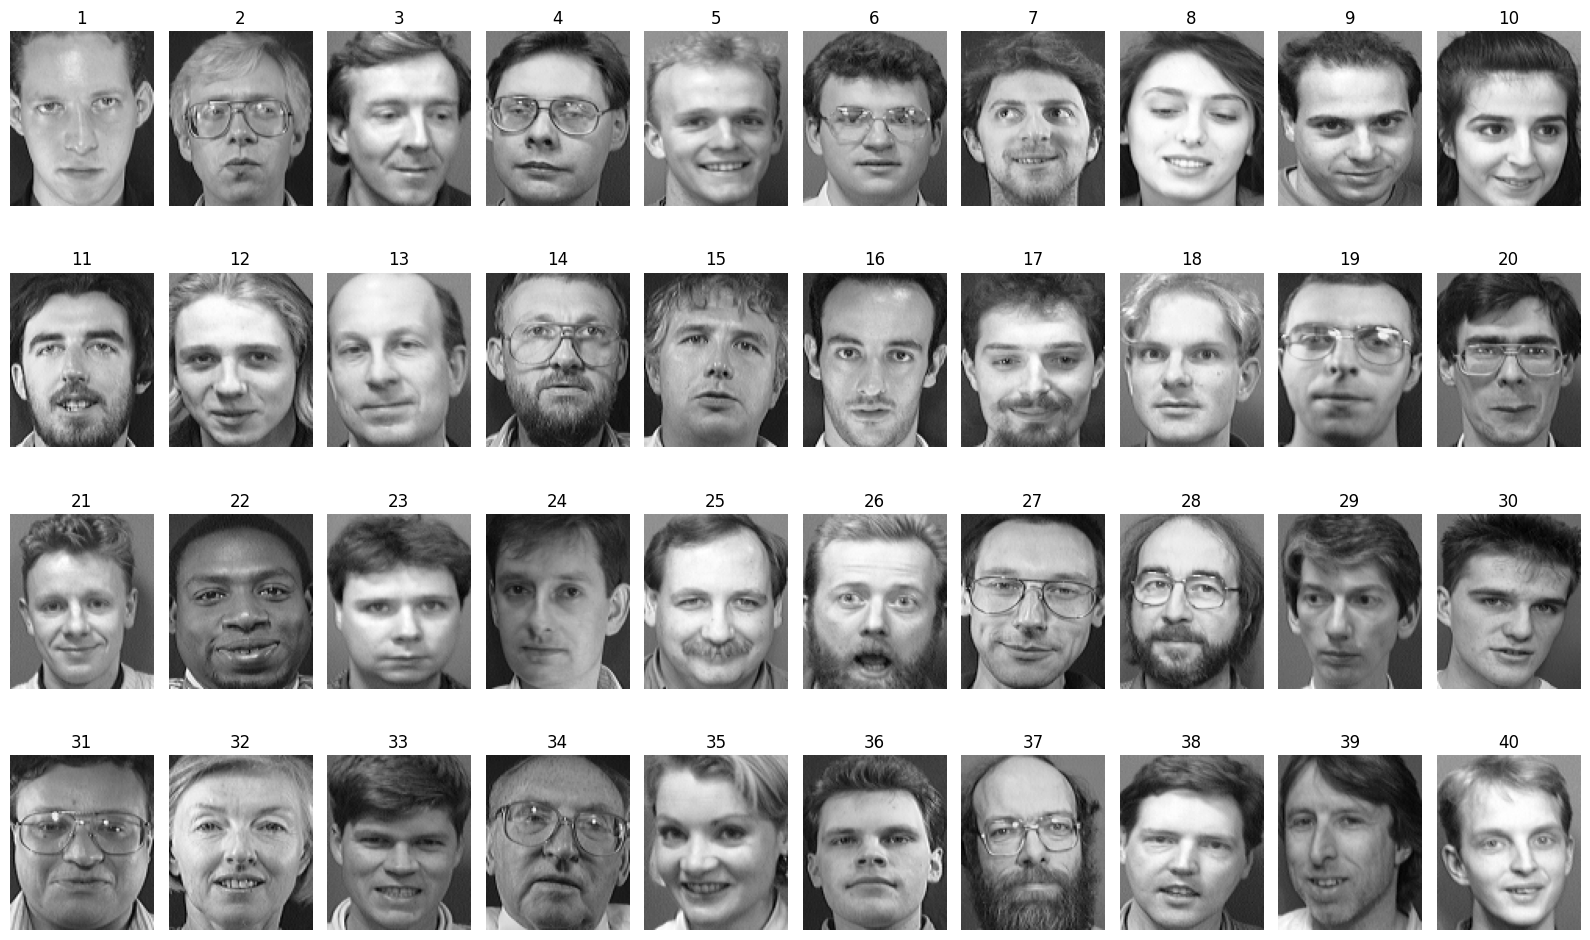

In [3]:
image_height = 112
image_width = 92

fig, axs = plt.subplots(4, 10, figsize=(16, 10))

# Flatten the array of axes
axs = axs.ravel()

for i in range(40):
    image_array = np.reshape(Data[(i) * 10], (image_height, image_width))
    axs[i].imshow(image_array, cmap="gray")
    axs[i].set_title(i + 1)
    axs[i].axis("off")

plt.tight_layout()
plt.show()

## Splitting The Dataset


In [4]:
X_train = Data[0::2]
X_test = Data[1::2]
y_train = labels[0::2]
y_test = labels[1::2]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(200, 10304)
(200, 10304)
(200, 1)
(200, 1)


# PCA


In [5]:
def get_PCA(training_data, alpha):
    # Compute the mean of the training data
    mean_face = np.mean(training_data, axis=0)
    # subtract the mean from the training data
    training_data_centralized = training_data - mean_face
    # compute the covariance matrix
    cov_matrix = training_data_centralized @ training_data_centralized.T
    # compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    # sort the eigenvectors descindigly by eigenvalues
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    # restore the original eigenvectors
    eigenvectors_converted = training_data_centralized.T @ eigenvectors
    # normalize the eigenvectors_converted
    eigenfaces = eigenvectors_converted / np.linalg.norm(eigenvectors_converted, axis=0)
    # compute the number of components to keep
    sum = 0
    no_components = 0
    for i in range(len(eigenvalues)):
        sum += eigenvalues[i]
        no_components += 1
        if sum / np.sum(eigenvalues) >= alpha:
            break
    # project the training data on the eigenfaces
    return mean_face, eigenfaces[:, :no_components]


mean_face, eigenfaces = get_PCA(X_train, 0.8)
print(eigenfaces.shape)

(10304, 35)


## Projection training Data and Test data


In [6]:
def PCA_Projected_data(training_data,testing_data,mean_face, eigenfaces):
    X_train_centered = training_data - mean_face
    X_train_projected = X_train_centered @ eigenfaces
    X_test_centered = testing_data - mean_face
    X_test_projected = X_test_centered @ eigenfaces
    return X_train_projected, X_test_projected

## Plotting The first 5 Eigen Faces


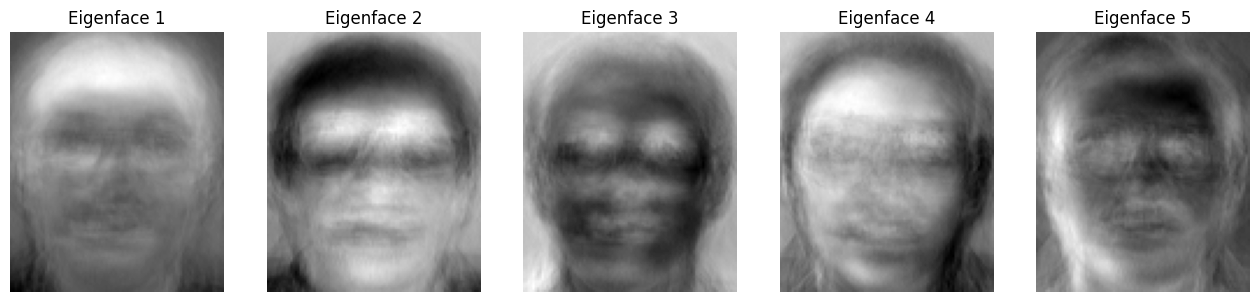

In [7]:
_, eigenfaces = get_PCA(X_train, 0.95)
# plotting first 5 eigenfaces
fig, axs = plt.subplots(1, 5, figsize=(16, 10))
for i in range(5):
    image_array = np.reshape(eigenfaces[:, i], (image_height, image_width))
    axs[i].imshow(image_array, cmap="gray")
    axs[i].set_title("Eigenface " + str(i + 1))
    axs[i].axis("off")

### Test PCA


In [23]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

def Test_PCA(training_data, testing_data, training_labels, testing_labels, alpha, k):
    mean_face, eigenfaces = get_PCA(training_data, alpha)
    X_train_pca, X_test_pca = PCA_Projected_data(training_data, testing_data, mean_face, eigenfaces)
    knn = KNeighborsClassifier(k, weights="distance")
    knn.fit(X_train_pca, training_labels.ravel())
    y_pred = knn.predict(X_test_pca)
    accuracy = accuracy_score(testing_labels, y_pred.ravel())
    f1 = f1_score(testing_labels, y_pred.ravel(), average='weighted')
    recall = recall_score(testing_labels, y_pred.ravel(), average='weighted')
    precision = precision_score(testing_labels, y_pred.ravel(), average='weighted')
    return accuracy, f1, recall, precision

In [24]:
accuracy, f1, recall, precision = Test_PCA(X_train, X_test, y_train, y_test, 0.85, 1)
print(f"PCA Accuracy: {accuracy}")
print(f"PCA F1 Score: {f1}")
print(f"PCA Recall: {recall}")
print(f"PCA Precision: {precision}")

PCA Accuracy: 0.955
PCA F1 Score: 0.9532196969696969
PCA Recall: 0.955
PCA Precision: 0.9648809523809524


## Classifier Tuning for PCA


In [9]:
alphas = [0.8, 0.85, 0.9, 0.95]
k_values = [1, 3, 5, 7, 9]
df = pd.DataFrame(index=alphas, columns=k_values)
for num_dominant_eigen_vectors in alphas:
    for k in k_values:
        accuracy = Test_PCA(X_train,X_test,y_train,y_test,num_dominant_eigen_vectors, k)
        df.loc[num_dominant_eigen_vectors, k] = accuracy

df

,1,3,5,7,9
0.80,0.945,0.92,0.895,0.905,0.88
0.85,0.955,0.935,0.915,0.895,0.875
0.90,0.955,0.925,0.91,0.89,0.87
0.95,0.96,0.92,0.9,0.89,0.875


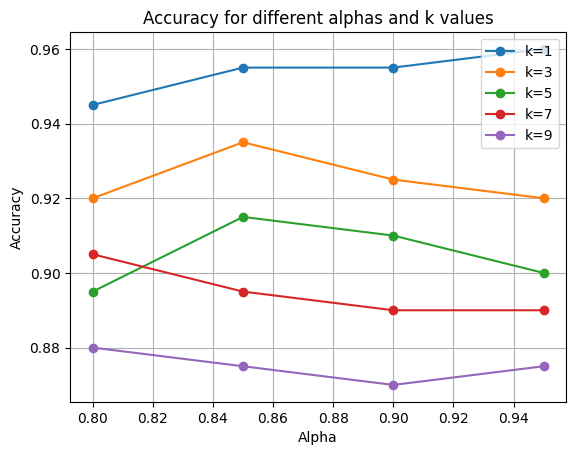

In [10]:
for k in k_values:
    plt.plot(df.index, df[k], marker="o", label=f"k={k}")

plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Accuracy for different alphas and k values")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

### Accuracy of PCA with respect to K (number of nearest neighbours)


In [15]:
alpha = [0.8, 0.85, 0.9, 0.95]
k_values = [1, 3, 5, 7, 9]
variants = [
    "PCA α = 0.8",
    "PCA α = 0.85",
    "PCA α = 0.9",
    "PCA α = 0.95",
    "LDA",
]
df = pd.DataFrame(index=variants, columns=k_values)
for num_dominant_eigen_vectors in alphas:
    for k in k_values:
        for i in range(4):
            pca_accuracy = Test_PCA(X_train,X_test,y_train,y_test,alpha[i], k)
            df.loc[variants[i], k] = str(pca_accuracy * 100) + "%"
       
df

,1,3,5,7,9
PCA α = 0.8,94.5%,92.0%,89.5%,90.5%,88.0%
PCA α = 0.85,95.5%,93.5%,91.5%,89.5%,87.5%
PCA α = 0.9,95.5%,92.5%,91.0%,89.0%,87.0%
PCA α = 0.95,96.0%,92.0%,90.0%,89.0%,87.5%
LDA,NaN,NaN,NaN,NaN,NaN


## Splitting Data 70% Train and 30% Test

In [16]:
def split_data(data,labels):
    bonus_x_train = np.zeros((280,10304))
    bonus_x_test = np.zeros((120,10304))
    bonus_y_train = np.zeros((280,1))
    bonus_y_test = np.zeros((120,1))
    # split each person's data into 7 training images and 3 testing images
    for  i in range (40):
        bonus_x_train[i*7:(i+1)*7] = data[i*10:i*10+7]
        bonus_x_test[i*3:(i+1)*3] = data[i*10+7:i*10+10]
        bonus_y_train[i*7:(i+1)*7] = labels[i*10:i*10+7]
        bonus_y_test[i*3:(i+1)*3] = labels[i*10+7:i*10+10]
    # shuffle the data
    indices = np.arange(280)
    np.random.shuffle(indices)
    bonus_x_train = bonus_x_train[indices]
    bonus_y_train = bonus_y_train[indices]   
    return bonus_x_train,bonus_x_test,bonus_y_train,bonus_y_test
bonus_x_train,bonus_x_test,bonus_y_train,bonus_y_test = split_data(Data,labels)

In [17]:
bonus_x_train, bonus_x_test, bonus_y_train, bonus_y_test = split_data(Data, labels)


In [18]:
mean_face, eigenfaces = get_PCA(bonus_x_train, 0.85)
X_train_pca, X_test_pca = PCA_Projected_data(bonus_x_train,bonus_x_test,mean_face, eigenfaces)
knn = KNeighborsClassifier(1, weights="distance")
knn.fit(X_train_pca, bonus_y_train.ravel())
y_pred = knn.predict(X_test_pca)
accuracy = accuracy_score(bonus_y_test, y_pred.ravel())
print("PCA Accuracy: " + str(accuracy))


PCA Accuracy: 0.9083333333333333


### Comparison Between Ordinary Split and Train Split in PCA

In [19]:
alpha = [0.8, 0.85, 0.9, 0.95]
k=1
df = pd.DataFrame(index=alpha, columns=["Original Split", "Bonus Split"])
for num_dominant_eigen_vectors in alpha:
    pca_accuracy = Test_PCA(X_train,X_test,y_train,y_test,num_dominant_eigen_vectors, k)
    df.loc[num_dominant_eigen_vectors, "Original Split"] = pca_accuracy
    bonus_pca_accuracy = Test_PCA(bonus_x_train,bonus_x_test,bonus_y_train,bonus_y_test,num_dominant_eigen_vectors, k)
    df.loc[num_dominant_eigen_vectors, "Bonus Split"] = bonus_pca_accuracy
df    

,Original Split,Bonus Split
0.80,0.945,0.908333
0.85,0.955,0.908333
0.90,0.955,0.916667
0.95,0.96,0.925


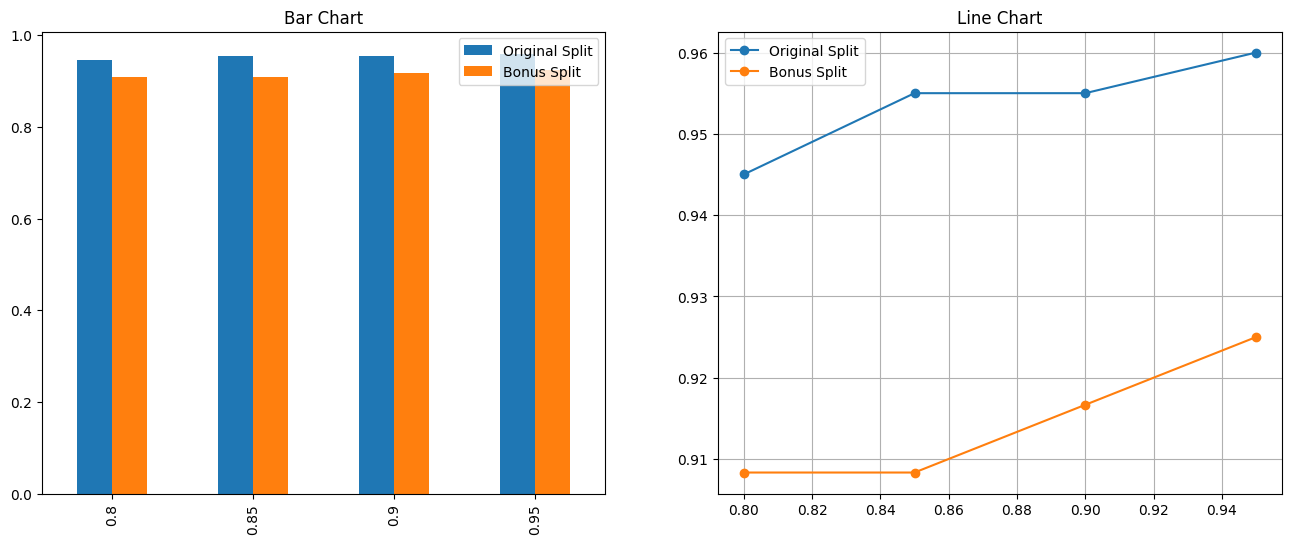

In [20]:
# plot the df as
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
df.plot(kind="bar", ax=ax[0])
df.plot(kind="line", ax=ax[1], marker="o")
ax[0].set_title("Bar Chart")
ax[1].set_title("Line Chart")
plt.grid(True)
plt.show()